<a href="https://colab.research.google.com/github/rdkdaniel/Quantum-Computers-and-ML-DL/blob/main/Quantum_Computers_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A General Review**

**Introduction**

Interesting Reads and Resources:


*   https://www.nature.com/articles/s41467-021-22539-9
*   https://ai.googleblog.com/2021/06/quantum-machine-learning-and-power-of.html
*   https://blog.paperspace.com/beginners-guide-to-quantum-machine-learning/
*   https://research.ibm.com/topics/quantum-machine-learning
*   https://www.nature.com/articles/s41567-021-01287-z



In [ ]:
#Good paper on power of data in Quantum ML: https://www.nature.com/articles/s41467-021-22539-9

In [ ]:
#Quantum advantage over a classical computer is often framed in terms of computational complexity classes. 
#Examples such as factoring large numbers and simulating quantum systems are classified as bounded quantum polynomial time (BQP) problems.
#Which are those thought to be handled more easily by quantum computers than by classical systems. 
#Problems easily solved on classical computers are called bounded probabilistic polynomial (BPP) problems

In [ ]:
#Google Research show:
#Learning algorithms equipped with data from a quantum process, such as a natural process like fusion or chemical reactions, form a new class of problems (which they call BPP/Samp).
#That efficiently perform some tasks that traditional algorithms without data cannot, and is a subclass of the problems efficiently solvable with polynomial sized advice (P/poly). 
#This demonstrates that for some machine learning tasks, understanding the quantum advantage requires examination of available data as well.

In [ ]:
#Checkout the image showing the intersection of BQP, BPP, BPP/Samp and P/Poly

# **Quantum Data**

In the section below, I follow the work of Huang et al. Their work shows how different datasets affect performance comparisons.

Furthermore, the authors try to understand how and when classical machine learning models can learn as well as quantum models.

To achieve these objectives, the project showcases an empirical performance separation between classical and quantum machine learning model via a carefully crafted dataset.

As such, the implementation below:


1.   Prepares a reduced dimension Fashion-MNIST dataset.
2.   Use quantum circuits to re-label the dataset and compute Projected Quantum Kernel features (PQK).
3.   Train a classical neural network on the re-labeled dataset and compare the performance with a model that has access to the PQK features.




## **Dependencies & Setup**

In [1]:
pip install tensorflow==2.7.0 tensorflow-quantum==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 21 kB/s 
     |████████████████████████████████| 10.5 MB 7.6 MB/s 
     |████████████████████████████████| 463 kB 55.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.7 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 6.1 MB 34.4 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 
     |████████████████████████████████| 100 kB 8.2 MB/s 
     |████████████████████████████████| 576 kB 64.0 MB/s 
     |████████████████████████████████| 1.0 MB 40.3 MB/s 
     |████████████████████████████████| 115 kB 59.9 MB/s 
     |████████████████████████████████| 641 kB 64.0 MB/s 
     |████████████████████████████████| 541 kB 47.5 MB/s 
     |████████████████████████████████| 541 kB 55.3 MB/s 
     |█████████████████████████████

In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [3]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

## **Data Prep**

Preparing the fashion-MNIST dataset for running on a quantum computer.

### **Downloading the fashion-MNIST dataset**

Getting the traditional fashion-mnist dataset. 

This is done using the tf.keras.datasets module

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


4431872/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Filtering the dataset to keep just the T-shirts/tops and dresses.

At the same time convert the label, y, to boolean: True for 0 and False for 3.

In [5]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [6]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


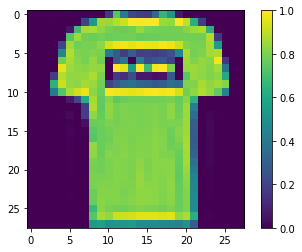

In [7]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()


### **Downscale the images**

Just like the MNIST example, you will need to downscale these images in order to be within the boundaries of current quantum computers. 

This time however you will use a PCA transformation to reduce the dimensions instead of a tf.image.resize operation.

In [8]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])


In [9]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))


New datapoint dimension: 10


The last step is to reduce the size of the dataset to just 1000 training datapoints and 200 testing datapoints.

In [10]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]


In [11]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))


New number of training examples: 1000
New number of test examples: 200


## **Relabeling and computing PQK features**

You will now prepare a "stilted" quantum dataset by incorporating quantum components and re-labeling the truncated fashion-MNIST dataset you've created above. 

In order to get the most seperation between quantum and classical methods, you will first prepare the PQK features and then relabel outputs based on their values. 

### **Quantum encoding and PQK features**